In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
# For handling warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utgoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Download the data

In [6]:
train_data = pd.read_csv('../data/train.csv', header=None)
train_data.columns=['polarity', 'title', 'text',]

val_data = pd.read_csv('../data/val.csv', header=None)
val_data.columns=['polarity', 'title', 'text',]

test_data = pd.read_csv('../data/test.csv')

In [7]:
# get all train data
X_train   = train_data['text']
y_train   = train_data['polarity']

# get val data
X_val    = val_data['text']
y_val    = val_data['polarity']

# get test data
X_test   = test_data['text']
y_test   = test_data['polarity']

print(f"Train Data Shape: {X_train.shape[0]:,}")
print(f"Validation Data Shape: {X_val.shape[0]:,}")
print(f"Test Data Shape: {X_test.shape[0]:,}")

print(" ")
print(f"Number of labels = 1 in train dataset as percentage: {((y_train == 1).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in train dataset as percentage: {((y_train == 2).sum() / (X_train.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 1 in val dataset as percentage: {((y_val == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_val == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 1 in test dataset as percentage: {((y_test == 1).sum() / (X_test.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in test dataset as percentage: {((y_test == 2).sum() / (X_test.shape[0])) * 100:0.2f}%")

Train Data Shape: 3,600,000
Validation Data Shape: 400,000
Test Data Shape: 33,161
 
Number of labels = 1 in train dataset as percentage: 50.00%
Number of labels = 2 in train dataset as percentage: 50.00%
 
Number of labels = 1 in val dataset as percentage: 50.00%
Number of labels = 2 in val dataset as percentage: 50.00%
 
Number of labels = 1 in test dataset as percentage: 2.45%
Number of labels = 2 in test dataset as percentage: 97.55%


# World Cloud

In [9]:
from wordcloud import WordCloud
stop = set(stopwords.words('english'))

In [10]:
def wordcloud_draw(dataset, color = 'white'):
    words = ' '.join(dataset)
    cleaned_word = ' '.join([word for word in words.split()
                           if (word != 'news' and word != 'text')])
    wordcloud = WordCloud(stopwords = stop,
                        background_color = color,
                        width = 2500, height = 2500).generate(cleaned_word)

    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

## Positive

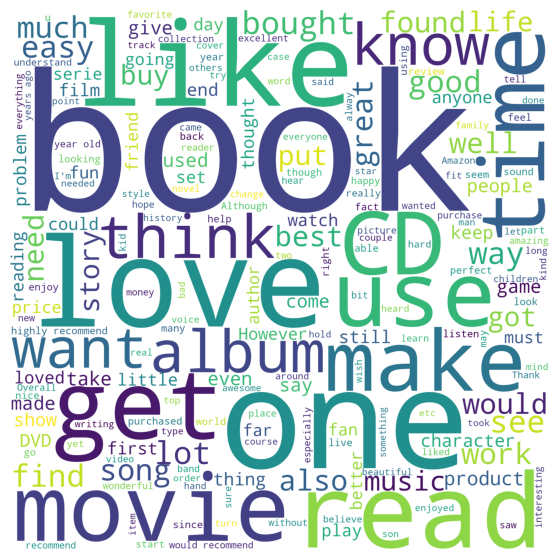

In [12]:
positive = train_data[train_data['polarity'] == 2]['text']
wordcloud_draw(positive, 'white')

## Negative

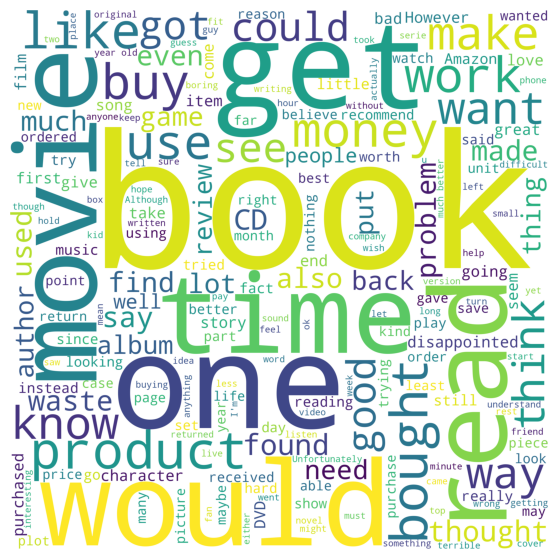

In [16]:
negative = train_data[train_data['polarity'] == 1]['text']
wordcloud_draw(negative, 'white')